# Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of "Labeled Faces in the Wild"

http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

Migrated to Jupyter for Orlando Python ML Workshop

## Intro

This shows how an unsuppervised learning algorithm can be used to preprocess data for a supervised learning algorithm. We'll be identifying faces using the underlying facial structure of our targets.

In [1]:
from time import time
import logging
import pylab as pl
import numpy as np
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Download and Describe

The dataset is a part of a larger [facial recognition database](http://vis-www.cs.umass.edu/lfw/) maintained by the University of Massachusetts. It contains headshots of public figures with approximately the same dimensions.

In [2]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# fot machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: {0}".format(n_samples))
print("n_features: {0}".format(n_features))
print("n_classes: {0}".format(n_classes))

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Create Training and Test Data

We're going to use sk-learn to randomly split our data into training and testing sets.

In [3]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Compute PCA

[Principal Component Analysis](http://scikit-learn.org/stable/modules/decomposition.html) is an unsupervised learning preprocessor which combines and reduces the dataset's features along the dimentions of greatest variability. For us, that means it will excentuate features of the face that are different from the rest.

In [4]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top {0} eigenfaces from {1} faces".format(n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in {0:.3f}s".format(time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in {0:.3f}s".format(time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.291s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.028s


## Train SVM Classifier

Now that our data is more manageable after computing the eigen vectors, we can feed it into a [Support Vector Machine](http://scikit-learn.org/stable/modules/svm.html) to do the classification. We're going to use a feature of sk-learn called GridSearchCV to find the optimal parameter settings rather than tuning them ourselves. We still have to supply potential settings, but it will figure out the best tuning with what we give it.

In [5]:
###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in {0:.3f}s".format(time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 15.639s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Test Set Evaluation

How did our model do? We'll use two matrix reports to show how accurate our model was for each target. Some quick vocab for the first report:

* Accuracy: How many targets were identified corrently
* Precision: How many positive results were actually positive (or low false positives)
* Recall: How many negative results were actually negative (or low true negatives)
* F1-score: Combined score favoring Precision
* F2-score: Combined score favoring Recall

In [6]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in {0:.3f}s".format(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.050s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.76      0.88      0.82        60
  Donald Rumsfeld       0.73      0.70      0.72        27
    George W Bush       0.92      0.87      0.89       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.83      0.83      0.83       322

[[  8   0   3   2   0   0   0]
 [  2  53   1   3   0   1   0]
 [  4   1  19   2   0   0   1]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  20   1   1]
 [  0   2   0   1   2   9   1]
 [  1   1   1   2   1   0  30]]


## Final Evaluation and Gallery Plot

Finally, lets actually see some of these images and the most influence eigen vector versions.

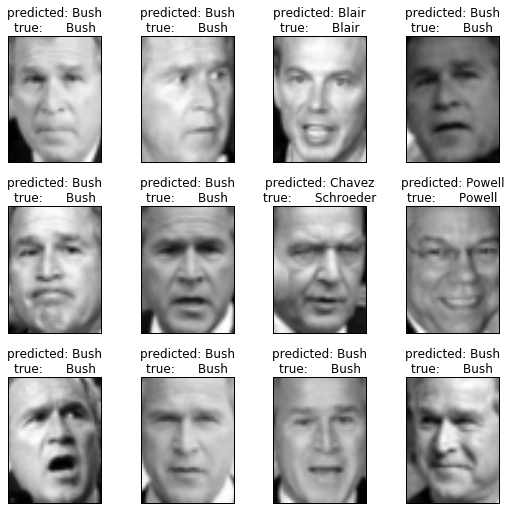

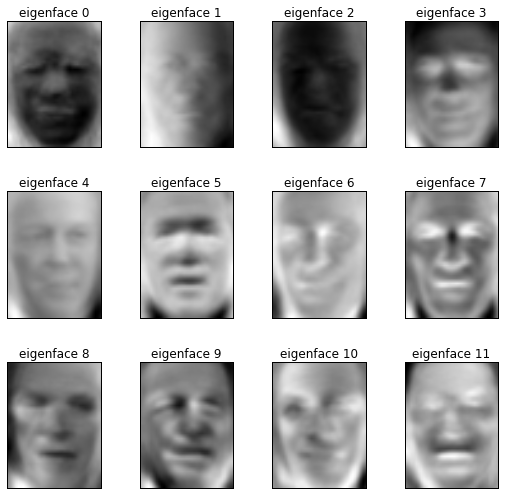

In [7]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return('predicted: {0}\ntrue:      {1}'.format(pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()